In [1]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Thu Jan 12 17:06:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
data_dir = '../input/hotdognothotdog'

# 1. 데이터불러오기

In [5]:
#transform = transforms.Compose([transforms.ToTensor()]) # 299 x 299 ~ 512 x 512 너무 사이즈 달라서

In [6]:
transform = transforms.Compose([transforms.Resize(size = (299, 299)), 
                                transforms.RandomHorizontalFlip(0.2),
                                transforms.RandomRotation(degrees = (0, 20)),
                                transforms.ToTensor()
                                ]) 

In [7]:
trainset = datasets.ImageFolder(root= data_dir + '/hotdog-nothotdog/train', transform=transform)
testset = datasets.ImageFolder(root= data_dir + '/hotdog-nothotdog/test', transform=transform)

In [8]:
trainset, validset = random_split(trainset, [2400, 600])

In [9]:
print(type(trainset), len(trainset)) 
print(type(validset), len(validset))
print(type(testset), len(testset)) 

<class 'torch.utils.data.dataset.Subset'> 2400
<class 'torch.utils.data.dataset.Subset'> 600
<class 'torchvision.datasets.folder.ImageFolder'> 644


# 2. 데이터 시각화

In [10]:
# 0번째 샘플 이미지
trainset[0][0].size(), trainset[0][1]

(torch.Size([3, 299, 299]), 0)

In [11]:
# 4번 샘플
sample_img = trainset[4][0]
sample_img.size()

torch.Size([3, 299, 299])

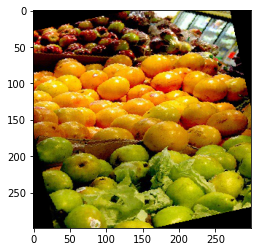

In [12]:
plt.imshow(sample_img.permute(1, 2, 0))

In [13]:
numpy_sample = sample_img.numpy()
numpy_sample.shape

(3, 299, 299)

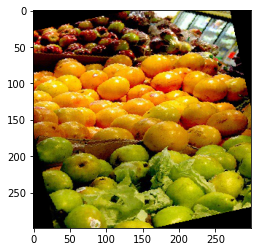

In [14]:
plt.imshow(numpy_sample.transpose(1, 2, 0))

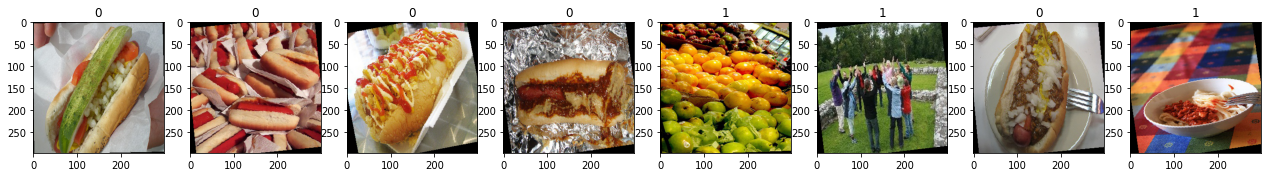

In [15]:
figure, axes = plt.subplots(nrows=1, ncols=8, figsize=(22, 6))
for i in range(8):
    axes[i].imshow(trainset[i][0].permute(1, 2, 0))
    axes[i].set_title(trainset[i][1])   

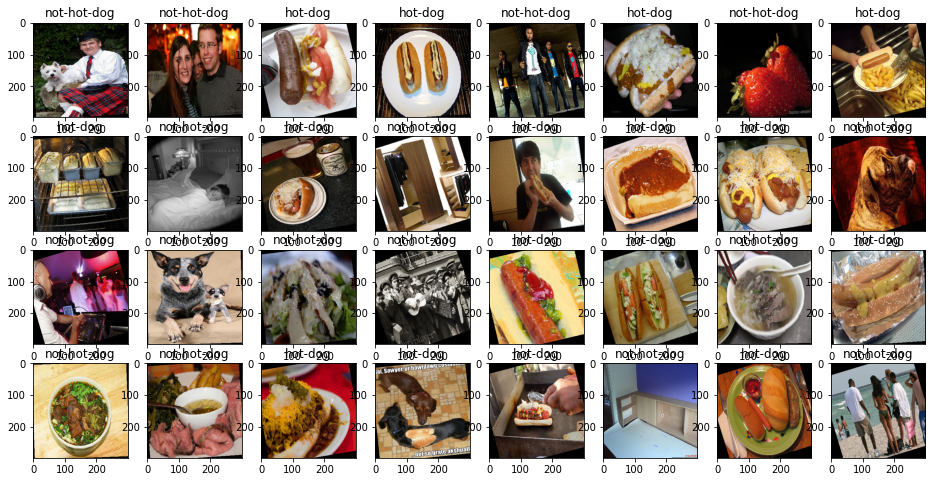

In [16]:
labels_map = {0 : 'hot-dog', 1 : 'not-hot-dog'}  

figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(trainset))
    image = trainset[rand_i][0].permute(1, 2, 0)
    axes[i].axis('on')
    axes[i].imshow(image)
    axes[i].set_title(labels_map[trainset[rand_i][1]])  

# 3. 데이터 적재

In [17]:
batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # 테스트용

In [18]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 150
<class 'torch.utils.data.dataloader.DataLoader'> 38
<class 'torch.utils.data.dataloader.DataLoader'> 41


In [19]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
print(images.size(), labels.size())

torch.Size([16, 3, 299, 299]) torch.Size([16])


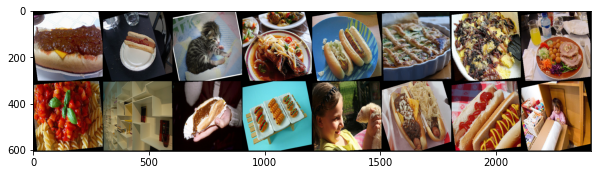

In [20]:
gird_img = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 100))
plt.imshow(gird_img.permute(1, 2, 0))

# 4. 모델 생성

In [21]:
from torch import nn 
from torch import optim 
from collections import OrderedDict

In [22]:
import torch.nn.functional as F
import re
import torch.utils.model_zoo as model_zoo

In [23]:
import torchvision.models as models
model = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [24]:
for param in model.parameters():
        param.requires_grad = False

In [25]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')

tensor([[-1.0040, -0.0937,  1.2348, -0.6269, -1.5510],
        [ 0.6281, -0.1677, -0.1212, -1.6059, -0.6166],
        [ 0.6874,  1.8082,  0.8174,  0.2972,  0.7804]])

In [26]:
import math
b = torch.empty(3)
bound = 1 / math.sqrt(w.size(1))
nn.init.uniform_(b, -bound, bound)

tensor([ 0.0620, -0.0184,  0.2642])

In [27]:
#__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']


#model_urls = {
#    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
#    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
#    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
#    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
#}

In [28]:
#class _DenseLayer(nn.Sequential):
#    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
#        super(_DenseLayer, self).__init__()
#        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
#        self.add_module('relu1', nn.ReLU(inplace=True)),
#        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
#                        growth_rate, kernel_size=1, stride=1, bias=False)),
#        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
#        self.add_module('relu2', nn.ReLU(inplace=True)),
#        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
#                        kernel_size=3, stride=1, padding=1, bias=False)),
#        self.drop_rate = drop_rate

#    def forward(self, x):
#        new_features = super(_DenseLayer, self).forward(x)
#        if self.drop_rate > 0:
#            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
#        return torch.cat([x, new_features], 1)

In [29]:
#class _DenseBlock(nn.Sequential):
#    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
#        super(_DenseBlock, self).__init__()
#        for i in range(num_layers):
#            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
#            self.add_module('denselayer%d' % (i + 1), layer)

In [30]:
#class _Transition(nn.Sequential):
#    def __init__(self, num_input_features, num_output_features):
#        super(_Transition, self).__init__()
#        self.add_module('norm', nn.BatchNorm2d(num_input_features))
#        self.add_module('relu', nn.ReLU(inplace=True))
#        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
#                                          kernel_size=1, stride=1, bias=False))
#        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

In [31]:
#class DenseNet(nn.Module):
#    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
#                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

#        super(DenseNet, self).__init__()
#        self.features = nn.Sequential(OrderedDict([
#            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
#            ('norm0', nn.BatchNorm2d(num_init_features)),
#            ('relu0', nn.ReLU(inplace=True)),
#            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
#        ]))

#        num_features = num_init_features
#        for i, num_layers in enumerate(block_config):
#           block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
#                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
#            self.features.add_module('denseblock%d' % (i + 1), block)
#            num_features = num_features + num_layers * growth_rate
#            if i != len(block_config) - 1:
#                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
#                self.features.add_module('transition%d' % (i + 1), trans)
#                num_features = num_features // 2
#        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
#        self.classifier = nn.Sequential(
#                nn.Dropout(0.5),
#                nn.Linear(num_features, num_classes)
#        )

#        for m in self.modules():
#            if isinstance(m, nn.Conv2d):
#                nn.init.kaiming_normal_(m.weight)
#            elif isinstance(m, nn.BatchNorm2d):
#                nn.init.constant_(m.weight, 1)
#                nn.init.constant_(m.bias, 0)
#            elif isinstance(m, nn.Linear):
#                nn.init.constant_(m.bias, 0)

#    def forward(self, x):
#        features = self.features(x)
#        x = F.relu(features, inplace=True)
#        x = F.adaptive_avg_pool2d(x, (1, 1)).view(features.size(0), -1)
#        x = self.classifier(x)
#        return x

In [32]:
model.classifier = nn.Sequential(nn.Linear(2208, 256),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(256, 2),
                                     nn.LogSoftmax(dim=1))

In [33]:
model.to(device)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [34]:
# model.classifier = nn.Linear(2208, 2)

In [35]:
#!pip install torchsummaryX

In [36]:
#from torchsummaryX import summary

In [37]:
#from torchsummary import summary

In [38]:
#summary(model, (3, 299, 299))

In [39]:
# summary(model, torch.randn((1, 3, 299, 299)))

# 5. 모델 컴파일

In [40]:
learning_rate = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [41]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1, verbose=True)

In [42]:
def validation(model, validloader, criterion):
    valid_accuracy = 0
    valid_loss = 0

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images) # 점수 반환
            _, preds = torch.max(logits, 1) # 16개에 대한 최종 예측
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            loss = criterion(logits, labels) # 16개에 대한 loss
      
            valid_accuracy += accuracy
            valid_loss += loss.item() # tensor 값을 꺼내옴
    

    return valid_loss, valid_accuracy 

In [43]:
from torch.utils.tensorboard import SummaryWriter
writer  = SummaryWriter()

In [44]:
train_loss_list = []
valid_loss_list = []
valid_acc_list = []

def train(model, epochs, criterion, optimizer):
    steps = 0
    min_loss = 10000
    max_accuracy = 0
    trigger = 0
    patience = 10 # for Early stopping

    steps_per_epoch = len(trainloader)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in iter(trainloader):
            steps += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images) # 예측
            loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환
            optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
            loss.backward()
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0:
                model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
                valid_loss, valid_accuracy = validation(model, validloader, criterion)

                # 시각화 표
                train_loss_list.append(train_loss/len(trainloader))
                valid_loss_list.append(valid_loss/len(validloader))
                valid_acc_list.append(valid_accuracy/len(validloader))
                
                # tensorboad 시각화
                writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
                writer.add_scalars("Loss/train and valid",
                                  {'train' : train_loss/len(trainloader),
                                   'valid' : valid_loss/len(validloader)}, epoch)
        
                writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)


                print('Epoch : {}/{}.....'.format(epoch+1, epochs),
                      'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
                      'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)),
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy/len(validloader)))
        
                # Best model 저장
                if valid_accuracy > max_accuracy: 
                    max_accuracy = valid_accuracy
                    torch.save(model.state_dict(), 'best_checkpoint.pth')

                # Early Stopping 
                if valid_loss > min_loss:
                    trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
                    print('trigger : ', trigger )
                    if trigger > patience:
                        print('Early Stopping!!!')
                        print('Traning step is finished!!')
                        writer.flush()  
                        return   
                    else:
                        trigger =0
                        min_loss = valid_loss

                    train_loss = 0
                    model.train()
                    # Learning Rate Scheduler
                    scheduler.step(valid_loss)
        writer.flush()      

In [45]:
epochs=55
train(model, epochs, criterion, optimizer)

Epoch : 1/55..... Train Loss : 0.658 Valid Loss : 0.601 Valid Accuracy : 0.870
Epoch : 2/55..... Train Loss : 0.559 Valid Loss : 0.509 Valid Accuracy : 0.887
Epoch : 3/55..... Train Loss : 0.484 Valid Loss : 0.431 Valid Accuracy : 0.896
Epoch : 4/55..... Train Loss : 0.435 Valid Loss : 0.389 Valid Accuracy : 0.906
Epoch : 5/55..... Train Loss : 0.385 Valid Loss : 0.343 Valid Accuracy : 0.928
Epoch : 6/55..... Train Loss : 0.350 Valid Loss : 0.308 Valid Accuracy : 0.918
Epoch : 7/55..... Train Loss : 0.325 Valid Loss : 0.284 Valid Accuracy : 0.933
Epoch : 8/55..... Train Loss : 0.306 Valid Loss : 0.265 Valid Accuracy : 0.931
Epoch : 9/55..... Train Loss : 0.294 Valid Loss : 0.249 Valid Accuracy : 0.928
Epoch : 10/55..... Train Loss : 0.274 Valid Loss : 0.229 Valid Accuracy : 0.938
Epoch : 11/55..... Train Loss : 0.266 Valid Loss : 0.229 Valid Accuracy : 0.924
Epoch : 12/55..... Train Loss : 0.247 Valid Loss : 0.209 Valid Accuracy : 0.938
Epoch : 13/55..... Train Loss : 0.246 Valid Loss 

### Train Loss

Text(0, 0.5, 'Train Loss')

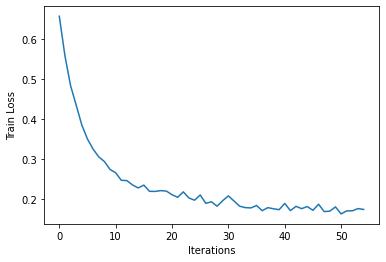

In [46]:
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Train Loss')

### Valid Loss

Text(0, 0.5, 'Valid Loss')

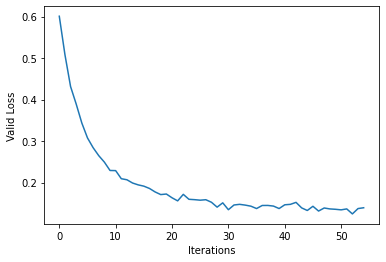

In [47]:
x = np.arange(len(valid_loss_list))
plt.plot(x, valid_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Valid Loss')

### Valid Accuracy

In [48]:
#valid_acc_list = valid_acc_list.cpu()

In [49]:
#x = np.arange(len(valid_acc_list))
#plt.plot(x, valid_acc_list)
#plt.xlabel('epochs')
#plt.ylabel('accuracy')

In [50]:
%load_ext tensorboard

In [51]:
%tensorboard --logdir=runs

In [52]:
writer.close()

# 7. 모델 예측

In [53]:
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

torch.Size([16, 3, 299, 299]) torch.Size([16])


In [54]:
rnd_idx = 10
images[rnd_idx:rnd_idx+1].shape, labels[rnd_idx:rnd_idx+1]

(torch.Size([1, 3, 299, 299]), tensor([0], device='cuda:0'))

In [55]:
img = images[rnd_idx:rnd_idx+1]
with torch.no_grad():
    model.eval() 
    logit = model.forward(img)
pred = logit.max(dim=1)[1]
pred == labels[rnd_idx]

tensor([True], device='cuda:0')

In [56]:
pred, labels[rnd_idx] # 예측 not-hot-dog 정답 hot-dog

(tensor([0], device='cuda:0'), tensor(0, device='cuda:0'))

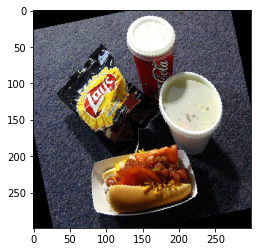

In [57]:
img = img.cpu()
plt.imshow(img[0].permute(1, 2, 0)) 

# 8. 모델 평가

In [58]:
def evaluation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0

    with torch.no_grad():
        model.eval()
        for images, labels in testloader: 
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images) 
            _, preds = torch.max(logits, 1) 
            correct = (preds == labels).sum()
      
            accuracy = correct / images.shape[0]
            loss = criterion(logits, labels) 
      
            test_accuracy += accuracy.item()
            test_loss += loss.item()
        
    print('Test Loss : ', test_loss/len(testloader))
    print('Test Accuracy : ', test_accuracy/len(testloader))

In [59]:
evaluation(model, testloader, criterion)

Test Loss :  0.12820533240532003
Test Accuracy :  0.961890243902439


# 9. 모델 저장

In [60]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [61]:
last_state_dict = torch.load('last_checkpoint.pth')

In [62]:
# last_model = DenseNet()

last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [63]:
evaluation(last_model, testloader, criterion)

Test Loss :  0.12840042170137167
Test Accuracy :  0.9634146341463414


In [64]:
best_state_dict = torch.load('best_checkpoint.pth')

In [65]:
# best_model = DenseNet()

best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [66]:
evaluation(best_model, testloader, criterion)

Test Loss :  0.1326257331614814
Test Accuracy :  0.9573170731707317
